# Opti Pipe


A Python library for optimizing underfloor heating pipe layouts in rooms with heat distribution simulations.


Opti-Pipe is a specialized tool for designing efficient pipe routing systems for underfloor heating. It provides algorithms to:

1. Model floor spaces with distributors and room connections
2. Create optimal pipe routing between distributors and rooms
3. Visualize heat distribution across the floor area
4. Optimize pipe layouts for maximum floor coverage

## Features

- **Graph-Based Routing**: Discretizes floor space into a grid to enable advanced routing algorithms
- **Multiple Routing Strategies**:
  - **Naive Router**: Direct path routing using centerline guidance
  - **Heuristic Router**: Advanced algorithm that maximizes floor coverage by finding longer paths
- **Heat Distribution Visualization**: GPU-accelerated heat diffusion simulation to visualize warming patterns
- **Flexible Configuration**: YAML-based configuration system for customizing all aspects of the model



In [7]:
from opti_pipe import Model, Floor, Distributor, Node, NodeType, RoomConnection, Graph
from opti_pipe.utils import load_config
from opti_pipe.router import NaiveRouter, HeuristicRouter

# Setup and Defining a Problem

A OO-Approach was used to Model the Domain. 
The Setup includes following steps:

1. loading the config obj
2. Define the Room by its corners
3. Set the Distrbutions Unit - where pipes are connected to -  in the room and define the inlet and outlet position within the distributior
4. place Room connections


## Constrains

- The implementation is tested to work for rectangular rooms only
- number of distribution nodes need to be same number as the room connection nodes (hence.. no Y intersection are allowed)
- heat loss is unit less and only gives a approximation 



In [8]:
config = load_config()  # Load configuration from data/config.yaml
grid_size = 0.3  # Define the grid cell size for discretizing the floor area

In [9]:
# Create a 5x5 meter floor area with corners at (0,0), (0,5), (5,5), and (5,0)
floor = Floor(config=config, corners=[(0,0), (0,5), (5,5), (5,0)])

# Create a distributor with 6 nodes (3 input-output pairs) along the bottom edge of the floor
# Each input node supplies heat (heat_per_node=1) which flows through the system
distributor = Distributor(config=config, nodes=(
    Node(config, 2.0, 0, node_type=NodeType.INPUT),   # Input node at x=2.0, y=0
    Node(config, 2.2, 0, node_type=NodeType.OUTPUT),  # Output node at x=2.2, y=0
    Node(config, 2.4, 0, node_type=NodeType.INPUT),   # Input node at x=2.4, y=0
    Node(config, 2.6, 0, node_type=NodeType.OUTPUT),  # Output node at x=2.6, y=0
    Node(config, 2.8, 0, node_type=NodeType.INPUT),   # Input node at x=2.8, y=0
    Node(config, 3.0, 0, node_type=NodeType.OUTPUT)), # Output node at x=3.0, y=0
    heat_per_node=1)  # Each input node provides 1 unit of heat

# Create room connections with input-output pairs located along the floor edges
# Each connection has a heat_loss value representing how much heat is lost in that room
room_connections = (
    # Left wall connection (heat loss: 0.8)
    RoomConnection(config,
                  output=Node(config, 0, 3.75, node_type=NodeType.OUTPUT),
                  input=Node(config, 0, 3.5, node_type=NodeType.INPUT),
                  heat_loss=0.8),
    # Right wall connection (heat loss: 0.5)
    RoomConnection(config,
                  output=Node(config, 5, 3, node_type=NodeType.OUTPUT),
                  input=Node(config, 5, 3.25, node_type=NodeType.INPUT),
                  heat_loss=0.5),
    # Top wall connection (heat loss: 0.3)
    RoomConnection(config,
                  output=Node(config, 2.6, 5, node_type=NodeType.OUTPUT),
                  input=Node(config, 2.4, 5, node_type=NodeType.INPUT),
                  heat_loss=0.3))

# Building the Model

lets init the model and render it first to eval the initial state


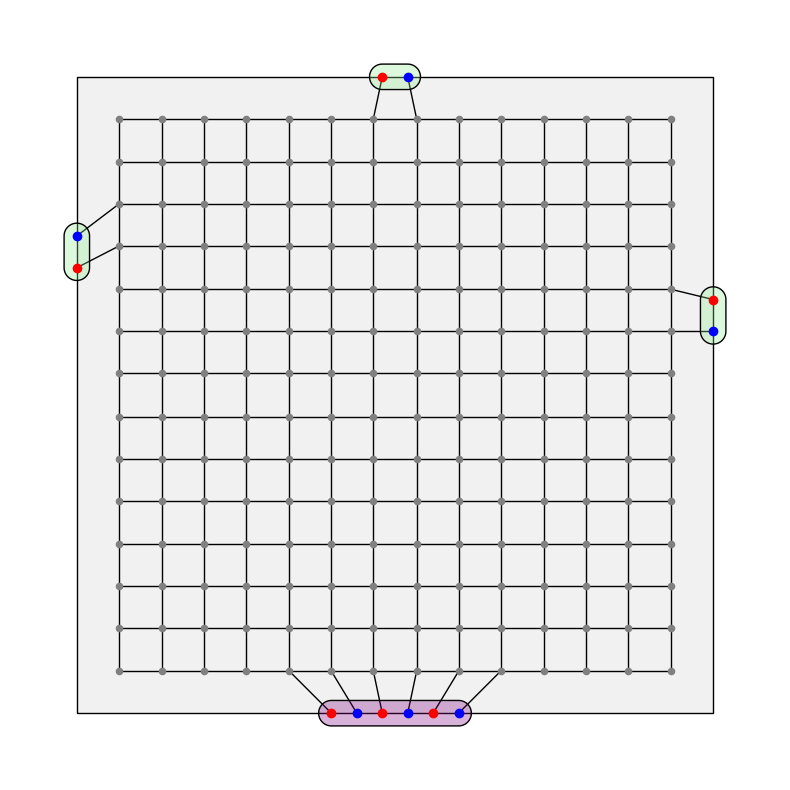

In [10]:
def get_model(grid_size: float) -> Model:
    """
    Creates and initializes a model for floor heating pipe routing.
    
    This function instantiates a Model object with the specified floor, distributor, 
    and room connections, then adds a graph based on the given grid size.
    
    Args:
        grid_size: The size of each grid cell in meters used to discretize the floor space.
                  Smaller values create finer-grained graphs but increase computation time.
    
    Returns:
        Model: A fully initialized model with a graph representation of the floor space.
    """
    model = Model(
        config=config,
        target_heat_input=100,  # Target total heat input for the system
        floor=floor,
        distributor=distributor,
        room_connections=room_connections)
    model.add_graph(grid_size)  # Create a graph representation with the specified grid size
    return model

# Initialize a new model and render it, showing the graph structure
model = get_model(grid_size)
model.render(show_graph=True)  # Display the grid graph and connection points

# Routing
## Naive Router 
Short path which is easy to layout and visually appealing.

Creates direct paths following centerlines between distributors and room connections.  
The implementation utilizes NetworkX's Dijkstra algorithm with a custom weight function to route through the graph.

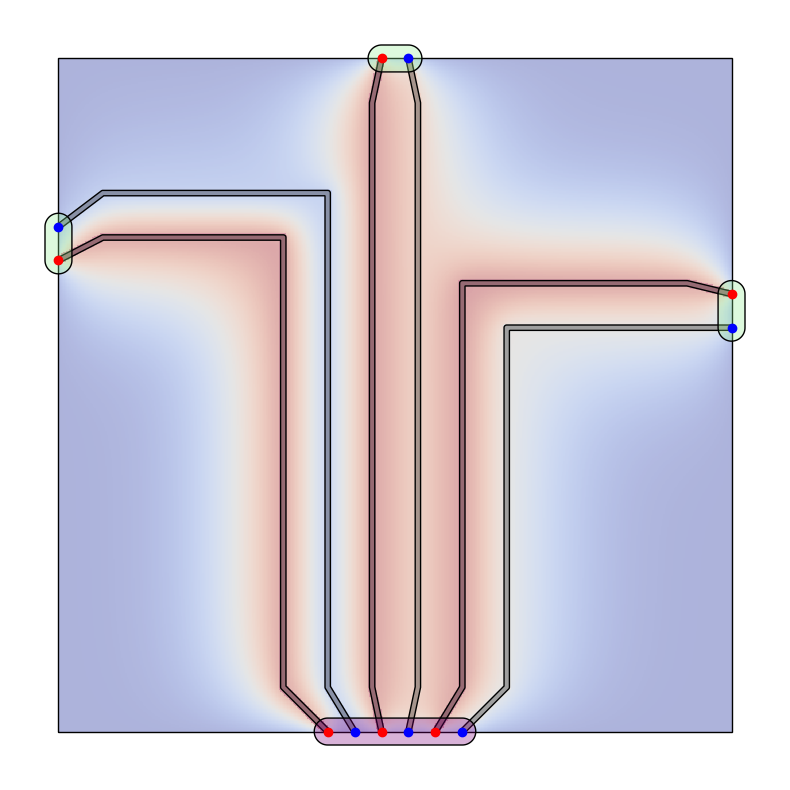

In [ ]:
# Create a new model instance for the naive router
model = get_model(grid_size)

# Initialize the NaiveRouter, which uses a centerline-based approach to find shortest paths
# The router takes the model and grid size as inputs
router = NaiveRouter(config, model, grid_size)

# Route all pipes in the model
# The route() method calculates optimal paths between distributor nodes and room connections
# It modifies the model in-place by adding pipe components
model = router.route()

# Render the model with heat distribution visualization
# show_graph=False: Don't display the underlying graph
# render_heat_distribution=True: Calculate and show heat propagation from pipes
model.render(show_graph=False, render_heat_distribution=True) # Note that this may take some time to compute 

## Heurtistic Router

Utilizes naive routes but maximizes floor coverage using DFS-based pathfinding.  
The core algorithm is a simple recursive function with backtracking, which traverses the search tree.  
Node selection and pruning are done via heuristic weights.

The algorithm uses the concepts of laziness/generators to return all solutions.  
Retrieving all solutions is not feasible.  
Therefore, a time budget is granted within which as many solutions as possible are calculated using different strategies.  
Finally, the best one is returned.

# Constraines

- Big Rooms and Small Grid-Sizes lead to very big sear



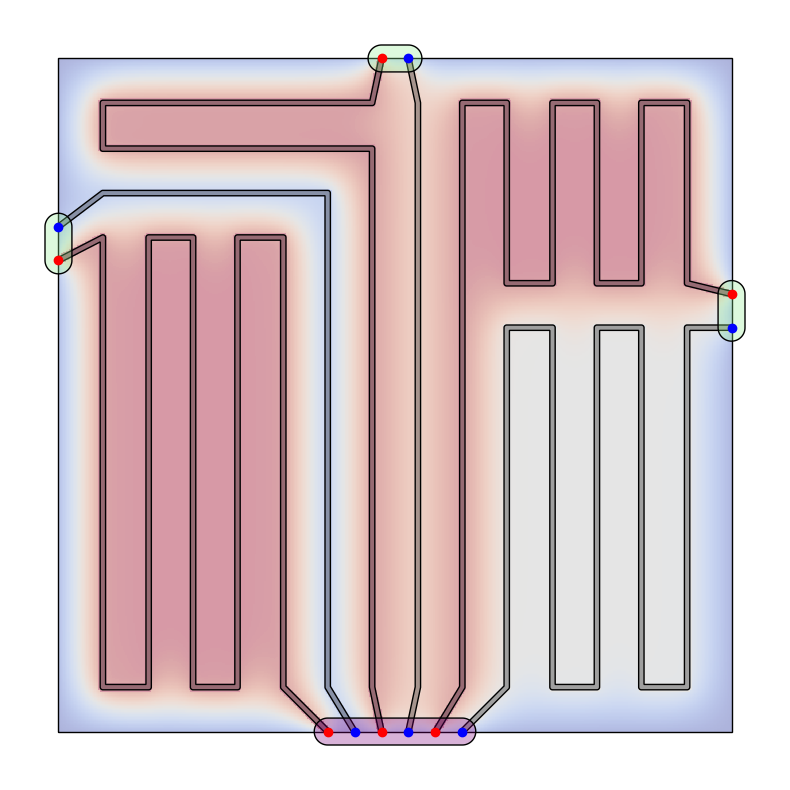

In [12]:
# Create a new model instance for the heuristic router
model = get_model(grid_size)

# Initialize the HeuristicRouter, which first uses the NaiveRouter to create initial paths
# and then improves upon them using a DFS-based approach to maximize pipe length
router = HeuristicRouter(config, model, grid_size,time_budget=1)

# Route all pipes in the model using the heuristic approach
# The HeuristicRouter internally:
# 1. First creates straight-line paths using the NaiveRouter
# 2. Then identifies isolated subgraphs where additional routing can occur
# 3. Reroutes pipes through these subgraphs to maximize coverage
model = router.route()

# Render the final model without showing the graph or heat distribution
model.render(show_graph=False, render_heat_distribution=True) # Note: rendering the heat distribution can take some time 
